# IIW Agent Playground

Welcome to the OpenMined Aries ACA-Py Juypter notebook playground. Using these notebooks you will be able to control your ACA-Py instance to interact with other agents being used at IIW. This should include mobile agents, other agent instances of this playground, trinsic agents and PICO agent applications. Basically any agent that supports the same aries-rfs as ACA-Py.

This is an experiment and might not work but hopefully it will be fun!

It is a playground because we have only created the skeleton to get you started. You can customise your "SSI Application" however you see fit by writing custom code right here within the notebooks. We have developed a python wrapper for the ACA-Py swagger api called the [aries-basic-controller](https://pypi.org/project/aries-basic-controller/) and a full tutorial series explaining how to use it to interact with your agent to perform basic agent flows [here](https://github.com/OpenMined/PyDentity/tree/master/tutorials/aries-basic-controller) if you get stuck.

Your agent is currently pointing at the Sovrin StagingNet and is using default storage for an indy wallet which is mapped using docker volumes so it should persist across multiple ./manage up's. Additionally the agents endpoint is exposed using ngrok, however this has a timelimit and will be a different url every time the docker is restarted. This *might* mess up the ability to communicate over connections, so the best advice is just to leave it running. Currently the agent is configured with all the --accept flags set that ACA-Py supports, feel free to change this. See the docker-compose.yml for more details.

We also included an attachment protocol so if you need to send files securely during IIW give it a try.




## Initialise your controller

In [1]:
%autoawait
import time
import qrcode
from aiohttp import FormData
import asyncio
from IPython.display import Image

from termcolor import colored,cprint
from attachment_controller.attachment_controller import AttachmentController
    
# Anyone know how to get env variables into juypter notebooks through docker easily?
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8022
WEBHOOK_BASE = ""
ADMIN_URL = "http://iiw-agent:8021"
# You may have changed us
API_KEY = "iiw_api_123456789"

# Note AttachmentController just extends the basic controller to include the new attachment endpoint
agent_controller = AttachmentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL, api_key=API_KEY)

IPython autoawait is `on`, and set to use `asyncio`


## Do you intend to issue credentials? If so execute this block to write a DID to the Sovrin StagingNet.

Note: Because the volume of the indy wallet storage is being mapped you should only need to do this **one time**

In [2]:
# Check if you have a public DID
response = await agent_controller.wallet.get_public_did()
print(response)

{'result': None}


In [3]:
import requests
import json 

# generate new DID
response = await agent_controller.wallet.create_did()

did_object = response['result']
print("New DID", did_object)

# write new DID to Sovrin Stagingnet
url = 'https://selfserve.sovrin.org/nym'

payload = {"network":"stagingnet","did": did_object["did"],"verkey":did_object["verkey"],"paymentaddr":""}

# Adding empty header as parameters are being sent in payload
headers = {}

r = requests.post(url, data=json.dumps(payload), headers=headers)

# Accept the TAA
response = await agent_controller.ledger.get_taa()
TAA = response['result']['taa_record']
TAA['mechanism'] = "service_agreement"

await agent_controller.ledger.accept_taa(TAA)

response = await agent_controller.wallet.assign_public_did(did_object["did"])
print("Your new public DID: ", response["result"]["did"])

New DID {'did': '5t9AFt6pLgXgzhBHtp69oM', 'verkey': '3fKdqgFqD1VJHSXZkv3nDk4FVZiP6fMoWUBFyNdHU93T', 'public': False}
Your new public DID:  5t9AFt6pLgXgzhBHtp69oM


## What Credentials do you intend to issue if any?

You could define your own scheme and write them to the ledger or write a credential definition for a schema that already exists on the ledger. Check out [IndyScan](https://indyscan.io/txs/SOVRIN_STAGINGNET/domain?page=1&pageSize=50&filterTxNames=[%22SCHEMA%22]&sortFromRecent=true) for some ideas.

In [ ]:
# Define you schema name - must be unique on the ledger
schema_name = "IIW Encounter"
# Can version the schema if you wish to update it
schema_version = "0.0.1"
# Define any list of attributes you wish to include in your schema
attributes = ["name"]

response = await agent_controller.schema.write_schema(schema_name, attributes, schema_version)
schema_id = response["schema_id"]
print(schema_id)


In [ ]:
# Write as many credential definitions as you like.
# Remember to save the cred_def_id's though. You will need these to issue credentials
response = await agent_controller.definitions.write_cred_def(schema_id)

cred_def_id = response["credential_definition_id"]
print(cred_def_id)

## Configure your handlers

This is how you respond to messages that your ACA-Py instance receives. Probably a good place to start if you want to customise your application.

In [2]:
# Receive basic messages
def messages_handler(payload):
    connection_id = payload["connection_id"]
    print("Handle message", payload, connection_id)
    


message_listener = {
    "handler": messages_handler,
    "topic": "basicmessages"
}

# Receive attachments
def attach_handler(payload):
    connection_id = payload['connection_id']
    print("Handle Attachment", payload, connection_id)
    print("Attachment Received")
    data = payload['content']
    filename = payload['filename']
    file_content = base64.b64decode(data)
    filepath = f"received_files/{filename}"
    f = open(filepath,'wb')
    f.write(file_content)
    f.close()

attach_listener = {
    "handler": attach_handler,
    "topic": "attachment"
}

# Issue credential messages
def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

# Receive connection messages
def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == "response":

        # Ensures connections moved to active
        loop = asyncio.get_event_loop()
        time.sleep(2)
        print(colored("Trust ping send to ConnectionId {0} to activate connection".format(connection_id), "blue", attrs=["bold"]))
        loop.create_task(agent_controller.messaging.trust_ping(connection_id, 'hello!'))

    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("ConnectionId: {0} is now active.".format(connection_id), "green", attrs=["bold"]))



# Note: You could have more than one listener & handler for the same topic
connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

# Receive proof messages
def proof_handler(payload):
    print("Handle present proof")
    print(payload)

proof_listener = {
    "topic": "present_proof",
    "handler": proof_handler
}



loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

agent_controller.register_listeners([message_listener, attach_listener, cred_listener, proof_listener, connection_listener], defaults=False)

## Create an Invitation

You may want to set an alias so you know who your connection represents.

Additionally if you are sharing this url in a chat for others to connect you might want to make it multi_use.


In [3]:
# Config
alias = "OM IIW Playground Connection"
multi_use = "true"

# Create Invitation
invite = await agent_controller.connections.create_invitation(alias=alias, multi_use=multi_use)
# invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']
print(invite["invitation"])

ClientConnectorError: Cannot connect to host iiw-agent:8021 ssl:default [Connect call failed ('192.168.96.3', 8021)]

Task exception was never retrieved
future: <Task finished coro=<run_in_terminal.<locals>.run() done, defined at /opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py:50> exception=UnsupportedOperation('fileno')>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py", line 55, in run
    return func()
  File "/opt/conda/lib/python3.7/site-packages/aries_basic_controller/helpers/utils.py", line 120, in <lambda>
    run_in_terminal(lambda: print_ext(*msg, color=color, **kwargs))
  File "/opt/conda/lib/python3.7/site-packages/aries_basic_controller/helpers/utils.py", line 103, in print_ext
    print_formatted(FormattedText(msg), **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/aries_basic_controller/helpers/utils.py", line 83, in print_formatted
    prompt_toolkit.print_formatted_text(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/shortcuts/utils.

## Accept Invitation
Copy in an invitation from someone else and create a connection

In [9]:
invitation = {
  "@type": "https://didcomm.org/connections/1.0/invitation",
  "label": "Root Pico",
  "recipientKeys": [
    "8kQUfRtd33zXVCgLqgxmPmd6pS2PvbDrNisN6kRNVFmZ"
  ],
  "serviceEndpoint": "http://192.168.0.19:8080/sky/event/ABQmx2x9moL7eVDRuHdNk1/null/sovrin/new_message"
}
connection = await agent_controller.connections.accept_connection(invitation)
connection_id = connection["connection_id"]

Connection message {'accept': 'manual', 'routing_state': 'none', 'invitation_key': '8kQUfRtd33zXVCgLqgxmPmd6pS2PvbDrNisN6kRNVFmZ', 'connection_id': '8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f', 'created_at': '2020-10-19 14:39:59.022530Z', 'invitation_mode': 'once', 'their_label': 'Root Pico', 'updated_at': '2020-10-19 14:39:59.022530Z', 'initiator': 'external', 'state': 'invitation'} 8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f
Connection message {'accept': 'manual', 'my_did': 'UnVT5E5B8LZwqtMzRYJFSb', 'request_id': 'c4567adf-3df8-4a05-9505-8bb2f16072b4', 'routing_state': 'none', 'invitation_key': '8kQUfRtd33zXVCgLqgxmPmd6pS2PvbDrNisN6kRNVFmZ', 'connection_id': '8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f', 'created_at': '2020-10-19 14:39:59.022530Z', 'invitation_mode': 'once', 'their_label': 'Root Pico', 'updated_at': '2020-10-19 14:39:59.033912Z', 'initiator': 'external', 'state': 'request'} 8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f


{'accept': 'manual',
 'my_did': 'UnVT5E5B8LZwqtMzRYJFSb',
 'request_id': 'c4567adf-3df8-4a05-9505-8bb2f16072b4',
 'routing_state': 'none',
 'invitation_key': '8kQUfRtd33zXVCgLqgxmPmd6pS2PvbDrNisN6kRNVFmZ',
 'connection_id': '8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f',
 'created_at': '2020-10-19 14:39:59.022530Z',
 'invitation_mode': 'once',
 'their_label': 'Root Pico',
 'updated_at': '2020-10-19 14:39:59.033912Z',
 'initiator': 'external',
 'state': 'request'}

Connection message {'their_did': 'Xc27XaVXBiNsaQzKZQpryB', 'accept': 'manual', 'my_did': 'UnVT5E5B8LZwqtMzRYJFSb', 'request_id': 'c4567adf-3df8-4a05-9505-8bb2f16072b4', 'routing_state': 'none', 'invitation_key': '8kQUfRtd33zXVCgLqgxmPmd6pS2PvbDrNisN6kRNVFmZ', 'connection_id': '8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f', 'created_at': '2020-10-19 14:39:59.022530Z', 'invitation_mode': 'once', 'their_label': 'Root Pico', 'updated_at': '2020-10-19 14:39:59.131689Z', 'initiator': 'external', 'state': 'response'} 8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f
Trust ping send to ConnectionId 8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f to activate connection
Connection message {'their_did': 'Xc27XaVXBiNsaQzKZQpryB', 'accept': 'manual', 'my_did': 'UnVT5E5B8LZwqtMzRYJFSb', 'request_id': 'c4567adf-3df8-4a05-9505-8bb2f16072b4', 'routing_state': 'none', 'invitation_key': '8kQUfRtd33zXVCgLqgxmPmd6pS2PvbDrNisN6kRNVFmZ', 'connection_id': '8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f', 'created_at': '2020-10-19 14:39:59.022530Z', '

In [13]:
connections = await agent_controller.connections.get_connections()
print(connections)

{'results': [{'their_did': '6goiFg2bQPbv8J6zSUsNX9', 'accept': 'manual', 'my_did': 'NX9EaX76JZccVaii1JwvfJ', 'request_id': '00ed25c6-00f3-4e4f-89ad-ae3018de52ba', 'routing_state': 'none', 'invitation_key': '8kQUfRtd33zXVCgLqgxmPmd6pS2PvbDrNisN6kRNVFmZ', 'connection_id': 'ea612b83-6c07-41e8-87d2-a540b62036a2', 'created_at': '2020-10-19 14:38:10.101981Z', 'invitation_mode': 'once', 'their_label': 'Root Pico', 'updated_at': '2020-10-19 14:38:10.257388Z', 'initiator': 'external', 'state': 'response'}, {'their_did': 'Xc27XaVXBiNsaQzKZQpryB', 'accept': 'manual', 'my_did': 'UnVT5E5B8LZwqtMzRYJFSb', 'request_id': 'c4567adf-3df8-4a05-9505-8bb2f16072b4', 'routing_state': 'none', 'invitation_key': '8kQUfRtd33zXVCgLqgxmPmd6pS2PvbDrNisN6kRNVFmZ', 'connection_id': '8b4c70ee-0baa-4dd5-9d7e-f2fb7a7e7c7f', 'created_at': '2020-10-19 14:39:59.022530Z', 'invitation_mode': 'once', 'their_label': 'Root Pico', 'updated_at': '2020-10-19 14:40:01.205351Z', 'initiator': 'external', 'state': 'active'}]}
Connecti

## Optionally generate a QrCode from url

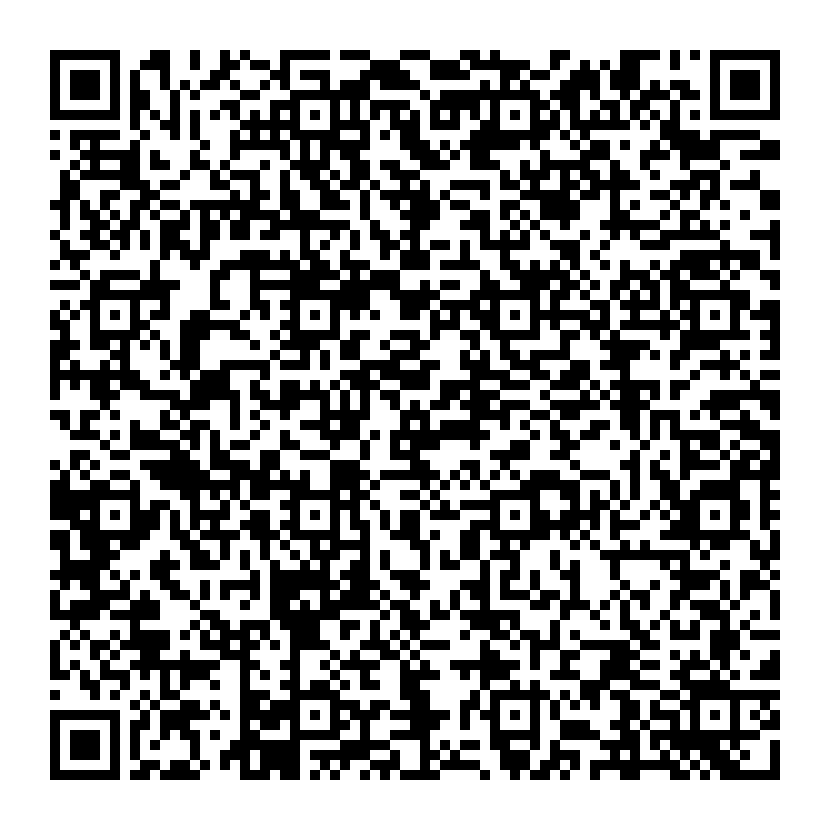

In [17]:
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

Image(width=400, filename='./issuer_agent_invite_QRcode.png')

## Send a Message

In [15]:
basic_message = "hello from Will"
response = await agent_controller.messaging.send_message('ea612b83-6c07-41e8-87d2-a540b62036a2', basic_message)
print("BASIC MESSAGE - Alice -> Bob")
print(response)

BASIC MESSAGE - Alice -> Bob
{}


## Send Attachment

Will only work if you are communicating with an agent that has this protocol installed. Basically anyone running this demo.

You must have the file you want to send accessible from this notebook. Upload it into the home page - https://localhost:8888. Or just send the IIW image that is already there.

In [12]:
file = "iiw.png"
content_type = "image/png"
data = FormData()
data.add_field('file',
               open(file, 'rb'),
               filename=file,
               content_type=content_type)
response = await attach_controller.protocol.send_attachment(connection_id, data)
print('Attachment- Alice-> Bob')
print(response)

NameError: name 'FormData' is not defined

## Issue Credential

Customise this however you like. 

In [ ]:
name=input("Please enter your name: ")
credential_attributes = [
    {"name": "name", "value": name},
]

record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

## Request a Presentation

You will need to know the schema_id you wish to verify attributes from


In [ ]:
schema_id = 'EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1'

print("Request proof of Fullname and Age range from Identity Holder")
#Set some variables

revocation = False
exchange_tracing = False

#Enable this to ask for attributes to identity a user
#TODO - change restriction to schemaId or credentialId

req_attrs = [
    {"name": "name", "restrictions": []},
]

# if revocation:
#     req_attrs.append(
#         {
#             "name": "skill",
#             "restrictions": [{"schema_id": schema_id}],
#             "non_revoked": {"to": int(time.time() - 1)},
#         },
#     )


#Set predicates for Zero Knowledge Proofs
# req_preds = [
#     # test zero-knowledge proofs
#     {
#         "name": "age",
#         "p_type": ">=",
#         "p_value": 21,
#         "restrictions": [{"schema_id": schema_id}],
#     }
# ]

indy_proof_request = {
    "name": "Proof of Name",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
#     "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
#     },
}

# if revocation:
#     indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = exchange_tracing
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": exchange_tracing,
}

In [ ]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)

## 6. Verify Proof Presentation

This is checking the signatures on the credentials presented against the credential schema and definition id stored and resolvable on the ledger. It is a bit of a big complicated object, so we show the common pattern for breaking it down, checking it's verified and accessing the data that has been presented.

In [ ]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)
print(verify)

### Verifying the State

Once verified through the agent framework api, the state should be 'verified', otherwise the presentation is invalid.

### Accessing the revealed attributes

In [ ]:
for (name, val) in verify['presentation']['requested_proof']['revealed_attrs'].items():
    ## This is the actual data that you want. It's a little hidden
    print(val['raw'])

### Accessing the self-attested attributes

In [ ]:
for (name, val) in verify['presentation']['requested_proof']['self_attested_attrs'].items():
    print(name)
    ## Slightly different for self attested attrs
    print(val)

In [6]:
await agent_controller.terminate()